In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.distributions import MultivariateNormal
import matplotlib.pyplot as plt
import numpy as np
from utility import *
import scipy.optimize as optimize
from torch.autograd import Variable
from torchmin import minimize

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [47]:
class PlanarTransform(nn.Module):
    """
    Implements planar transform: f(z)=z+u*h(w^T*z+b)
    with h=tanh.
    *The activation function is a choice in Planar Flows.*
    NEED TO IMPLEMENT INVERSES
    Equationsf from: https://arxiv.org/pdf/1912.02762v2.pdf.
    """
    def __init__(self, dim):
        """
        Init learnable parameters in transform, w, b & u.
        """
        super().__init__()
        self.w = nn.Parameter(torch.randn(1, dim).normal_(0, 0.1))
        self.b = nn.Parameter(torch.randn(1).normal_(0, 0.1))
        self.u = nn.Parameter(torch.randn(1, dim).normal_(0, 0.1))
        
    def forward(self, z):
        #Non-linearity chosen as tanh.
        linearity = torch.matmul(self.w, z.permute(1,0)).permute(1,0)+self.b
        transform = z + self.u*torch.tanh(linearity)
        return transform     
    
    def log_determ(self, z):
        #Derivative of tanh is (1-tanh)
        linearity = torch.matmul(self.w, z.permute(1,0)).permute(1,0)+self.b
        psi = torch.matmul((1-torch.tanh(linearity)**2), self.w)
        det = (1+torch.matmul(self.u, psi.permute(1,0))).abs()
        inverse_log_determ = torch.log(det)
        return inverse_log_determ
    
    #def inverse(self, z):
    #    linearity = torch.matmul(self.w, z.permute(1,0)).permute(1,0)+self.b
    #    transform = z + self.u*torch.tanh(linearity)
    #    return transform       
        
    #def inverse_log_determ(self, z):
    #    linearity = torch.matmul(self.w, z.permute(1,0)).permute(1,0)+self.b
    #    psi = torch.matmul((1-torch.tanh(linearity)**2), self.w)
    #    det = (1+torch.matmul(self.u, psi.permute(1,0))).abs()
    #    inverse_log_determ = torch.log(det)
    #    return inverse_log_determ
    
class PlanarFlow(nn.Module):
    """
    Now create the planar flow. Stack layers of transforms and forward.
    *K is a choice in planar flows.*
    """
    def __init__(self, dim, K):
        super().__init__()
        
        self.transform_layers = [PlanarTransform(dim) for i in range(K)]
        self.model = nn.Sequential(*self.transform_layers)
        
    def forward(self, z):
        log_det_J = 0
        
        for layer in self.transform_layers:
            log_det_J += layer.log_determ(z)
            z = layer(z)
            
        return z, log_det_J

    def sample(self, z):
        """
        Turns out we cannot do the inverse analytically, so instead we do it numerically....
        """
        
        x0 = torch.randn(size=(1,2))  # Initial guess
        
        def func(x0):
            x = self.forward(x0)[0]
            return torch.norm((z-x)**2, dim=1)
        
        final_guess = minimize(func, x0,  method='newton-cg')
        
        return final_guess.x


In [55]:
dim = 2
K = 64
batch_size= 64
epochs= 1000
lr = 0.001

planar_flow = PlanarFlow(dim=dim, K=K)
dataset = Datasets("moons")
train_loader = DataLoader(dataset, batch_size=batch_size,shuffle=False)
loss_func = TrainingLoss(dim=dim)
optimiser = torch.optim.Adam(planar_flow.parameters(), lr=lr)

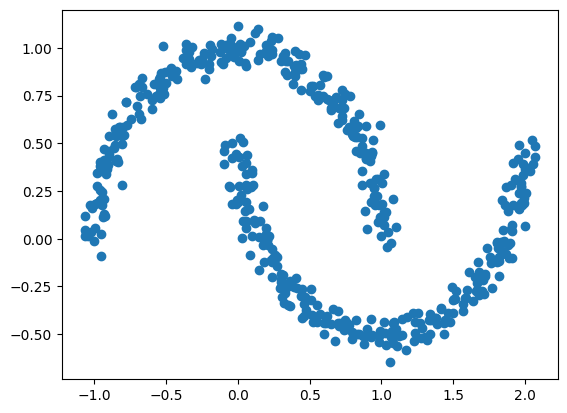

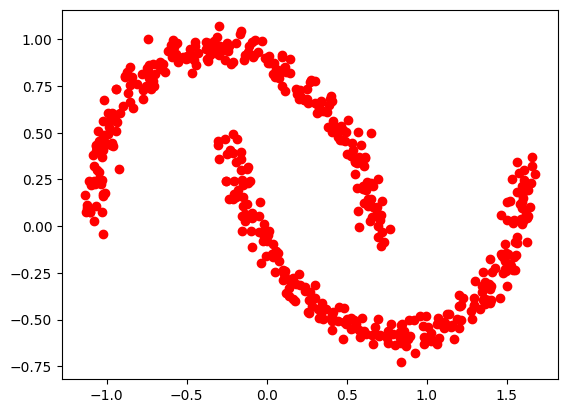

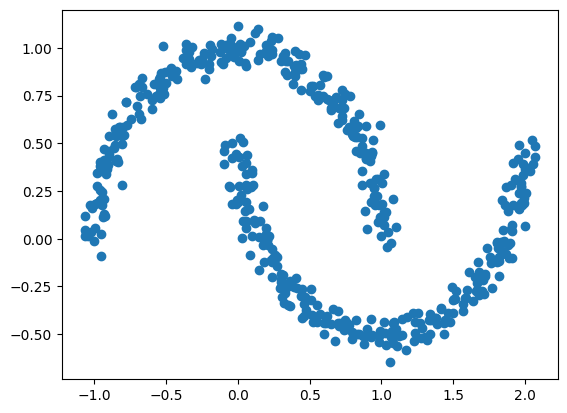

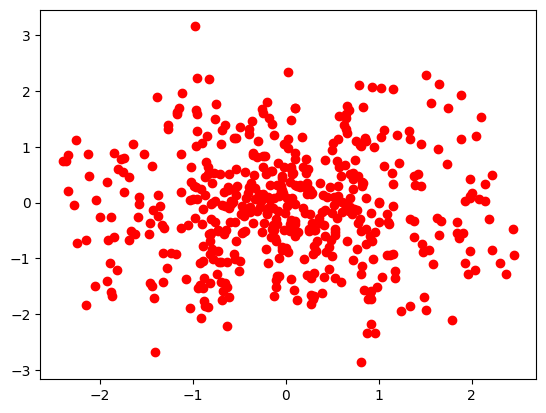

In [56]:
for i in range(epochs):
    z_list = []
    x_list = []
    for step, data in enumerate(train_loader):
        #Pass batch through flow.
        optimiser.zero_grad()
        z0, det_J = planar_flow(data)
        loss = loss_func(z0, det_J)
        z_list.append(z0)
        x_list.append(data)
        # Training step. 
        loss.backward()
        optimiser.step()
    if i == 0:
        x_list = torch.cat(x_list, 0)
        z_list = torch.cat(z_list, 0)
        plt.scatter(x_list[:,0].detach().numpy(), x_list[:,1].detach().numpy())
        plt.show()
        plt.scatter(z_list[:,0].detach().numpy(), z_list[:,1].detach().numpy(), color="r")
        plt.show()
x_list = torch.cat(x_list, 0)
z_list = torch.cat(z_list, 0)
plt.scatter(x_list[:,0].detach().numpy(), x_list[:,1].detach().numpy())
plt.show()
plt.scatter(z_list[:,0].detach().numpy(), z_list[:,1].detach().numpy(), color="r")
plt.show()

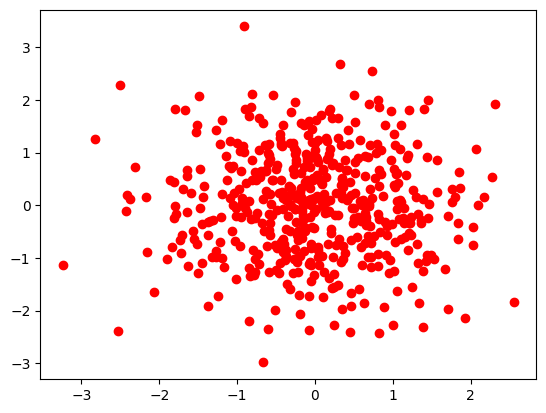

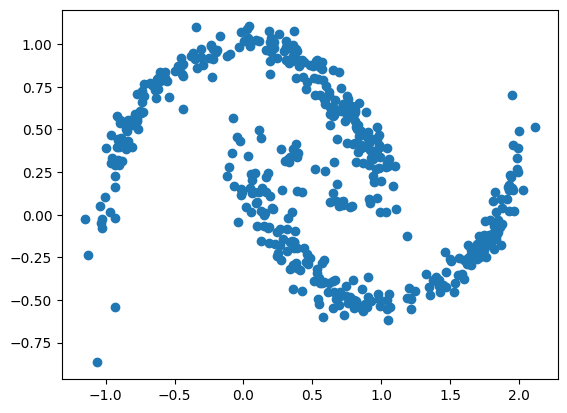

In [57]:
x_list = []
z_list = []
prior = MultivariateNormal(torch.zeros(dim), torch.eye(dim))
for i in range(500):
    sample_from_prior = prior.rsample()
    z_list.append(sample_from_prior.detach().numpy())
    x = planar_flow.sample(sample_from_prior.unsqueeze(0))
    x_list.append(x.squeeze().detach().numpy())
plt.scatter(torch.Tensor(z_list)[:,0], torch.Tensor(z_list)[:,1], color="r")
plt.show()
plt.scatter(torch.Tensor(x_list)[:,0], torch.Tensor(x_list)[:,1])
plt.show()